# Quant/Algo Trading on Bitcoin - Analysis and Backtesting

# Notebook 02 - Stratgies Backtesting

**By: [Jonathan Yeung](https://github.com/jonathan-yeung)**

In this notebook, I backtest and compare two trading strategies with the Buy-and-Hold benchmark:
- Mean Reversion, using Bollinger Bands
- Trend Following, using SMA Crossover

---

# Imports

In [31]:
# data fetching
import yfinance as yf

# data manipulation
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# misc
import os

# Data Preparation

In [32]:
file_path = ""

In [33]:
check_file = os.path.isfile(file_path + "data/raw.csv")

check_file

True

In [34]:
df = pd.read_csv(file_path + "data/raw.csv")
df["Date"] = pd.to_datetime(df["Date"], utc=True)
df.set_index("Date", inplace=True)
df.index = df.index.strftime("%Y-%m-%d")
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


As we will use only the close prices in the strategies, let us visualize the price chart here again with only the close prices.

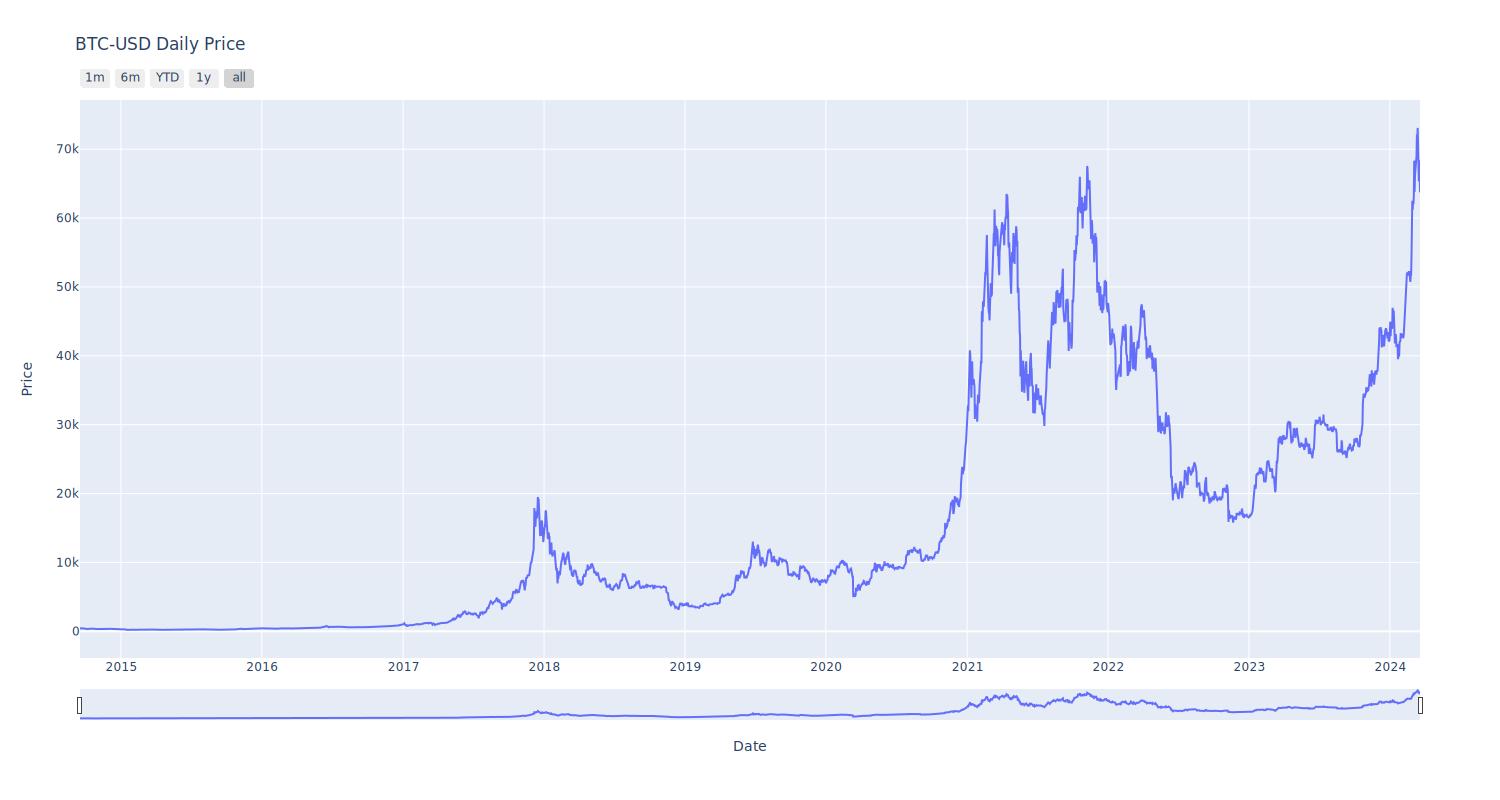

In [35]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df["Close"], mode='lines', name="price"))

fig.update_layout(
    yaxis_title="Price",
    xaxis_title="Date",
    title="BTC-USD Daily Price",
    hovermode="x unified",
    width=1500,
    height=800
)

# range slider and selector
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
fig.update_xaxes(rangeslider_thickness = 0.05)
fig.show(renderer="svg")

# Strategy Backtesting

We are going to backtest and compare two trading strategies with the Buy-and-Hold benchmark:
- Mean Reversion, using Bollinger Bands
- Trend Following, using SMA Crossover

Comparisons will be mainly based on:
- Equity Curve
- Return On Capital (Cumulative Return)
- Maximum Drawdown

Here, we omit the trading costs in the backtesting as an initial observation on the performance of the strategies. If we want to proceed with any strategy, the trading costs should be taken into account in further backtesting. One should also be aware of price slippage, which could affect the actual performance of the strategy in execution.

## Mean Reversion - Using Bollinger Bands

Strategy:

Here we use SMA-20 and 2 standard deviations for the Bollinger Bands
- Long if the price is lower than the lower band
- Short if the price is higher than the higher band
- Neutral if the price crosses the SMA

Dataset used for backtesting:

BTC-USD daily close prices from 2014-09-17 to 2024-01-01

In [36]:
class MRBackTester():
    '''
    Class for the backtesting of Mean Reversion strategies based on Bollinger Bands
    '''
    def __init__(self, symbol, SMA, sd, start, end, tc):
        '''
        Parameters
        ==========
        symbol: str
        ticker symbol to be backtested

        SMA: int
        simple moving average in days

        sd: int
        distance for lower/upper bands in standard deviation units

        start: str
        start date for data import

        end: str
        end date for data import

        tc: float
        proportional transaction/trading costs per trade

        Methods
        =======
        load_data:
        imports data from the csv file

        prep_data:
        prepares data for strategy backtesting

        test_strategy:
        backtests the strategy

        plot_results:
        plots the results of the strategy and compares to Buy-and-Hold
        '''
        self.symbol = symbol
        self.SMA = SMA
        self.sd = sd
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.load_data()
        self.prep_data()

    def __repr__(self):
        rep = "MRBackTester(symbol = {}, SMA = {}, sd = {}, start = {}, end = {}, tc = {})"
        return rep.format(self.symbol, self.SMA, self.sd, self.start, self.end, self.tc)

    def load_data(self):
        '''
        imports data from the csv file
        '''
        raw = pd.read_csv(file_path + "data/raw.csv") # the file path
        raw["Date"] = pd.to_datetime(raw["Date"], utc=True)
        raw.set_index("Date", inplace=True)
        raw.index = raw.index.strftime("%Y-%m-%d")
        raw.dropna(inplace=True)
        raw = raw.loc[self.start:self.end, ["Close"]].copy()
        raw.rename(columns={"Close": "price"}, inplace=True)
        self.data = raw
    
    def prep_data(self):
        '''
        prepares data for strategy backtesting
        '''
        data = self.data.copy()
        data["log_return"] = np.log(data / data.shift(1))
        data["SMA"] = data["price"].rolling(self.SMA).mean()
        data["upper"] = data["SMA"] - data["price"].rolling(self.SMA).std() * self.sd
        data["lower"] = data["SMA"] + data["price"].rolling(self.SMA).std() * self.sd
        self.data = data

    def test_strategy(self):
        '''
        backtests the strategy:
        long if the price is higher than the upper bound of BB,
        short if the price is lower than the lower bound of BB,
        neutral if the price crosses the SMA
        '''
        data = self.data.copy().dropna()

        # strategy
        data["distance"] = data.price - data.SMA
        data["position"] = np.where(data.price < data.lower, 1, np.nan)
        data["position"] = np.where(data.price > data.upper, -1, data.position)
        data["position"] = np.where(data.distance * data.distance.shift(1) < 0, 0, data.position)
        data.position = data.position.ffill().fillna(0)

        # strategy returns, net of trading costs
        data["lr_strategy"] = data.position.shift(1) * data.log_return
        data.dropna(inplace=True)
        data["trades"] = data.position.diff().fillna(0).abs()
        data.lr_strategy = data.lr_strategy - data.trades * self.tc

        # cumulative returns, MDD - BnH vs strategy
        data["cr_BnH"] = data.log_return.cumsum().apply(np.exp)
        data["cr_strategy"] = data.lr_strategy.cumsum().apply(np.exp)
        data["cummax_BnH"] = data.cr_BnH.cummax()
        data["mdd_BnH"] = (data.cummax_BnH - data.cr_BnH).cummax()
        data["cummax_strategy"] = data.cr_strategy.cummax()
        data["mdd_strategy"] = (data.cummax_strategy - data.cr_strategy).cummax()
        self.results = data

        roc = data["cr_strategy"].iloc[-1] - 2 * self.tc # return on capital of the strategy
        outperf = roc - data["cr_BnH"].iloc[-1] # out-/under-performance of the strategy vs Buy-and-Hold
        mdd_BnH = data.mdd_BnH.max()
        mdd_strategy = data.mdd_strategy.max()
        return round(roc, 6), round(outperf, 6), round(mdd_BnH, 6), round(mdd_strategy, 6)
    
    def plot_results(self):
        '''
        plots the results of the strategy and compares to Buy-and-Hold
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            fig = make_subplots(rows=3,
                                cols=1,
                                subplot_titles=("Equity Curve (Cumulative Returns)", "Positions", "Maximum Drawdown"),
                                row_width=[0.34, 0.33, 0.33],
                                vertical_spacing=0.1)
            
            # equity curve
            fig.append_trace(go.Scatter(x=self.results.index, y=self.results["cr_BnH"], mode='lines', name="cr_BnH", legendgroup = '1'),
                             row=1, col=1)
            fig.append_trace(go.Scatter(x=self.results.index, y=self.results["cr_strategy"], mode='lines', name="cr_strategy", legendgroup = '1'),
                             row=1, col=1)
            
            # positions
            fig.append_trace(go.Scatter(x=self.results.index, y=self.results["position"], mode='lines', name="position", legendgroup = '2'),
                             row=2, col=1)

            # maximum drawdown
            fig.append_trace(go.Scatter(x=self.results.index, y=self.results["mdd_BnH"], mode='lines', name="mdd_BnH", legendgroup = '3'),
                             row=3, col=1)
            fig.append_trace(go.Scatter(x=self.results.index, y=self.results["mdd_strategy"], mode='lines', name="mdd_strategy", legendgroup = '3'),
                             row=3, col=1)
            
            fig.update_layout(width=1000, height=1000,
                              title=f"{self.symbol} | Mean Reversion with BB({self.SMA}, {self.sd})",
                              hovermode="x unified",
                              legend_tracegroupgap=270)
            fig.show(renderer="svg")

In [37]:
mrtester = MRBackTester("BTC-USD", 20, 2, "2014-09-17", "2024-01-01", 0)

In [38]:
mr_roc, mr_outperf, mdd_BnH, mr_mdd = mrtester.test_strategy()

print("Backtesting results for the Mean Reversion strategy")
print("========")
print(f"Return On Capital: {mr_roc*100:.2f}%")
print(f"Under-/Out-performance vs Buy-and-Hold: {mr_outperf*100:.2f}%")
print(f"Maximum Drawdown of Buy-and-Hold: {mdd_BnH*100:.2f}%")
print(f"Maximum Drawdown of the strategy: {mr_mdd*100:.2f}%")

Backtesting results for the Mean Reversion strategy
Return On Capital: 0.46%
Under-/Out-performance vs Buy-and-Hold: -13380.38%
Maximum Drawdown of Buy-and-Hold: 15687.01%
Maximum Drawdown of the strategy: 183.20%


Let's also observe the strategy and its backtesting results on charts.

The Bollinger Bands generated from the BTC-USD prices are shown in the graph below.

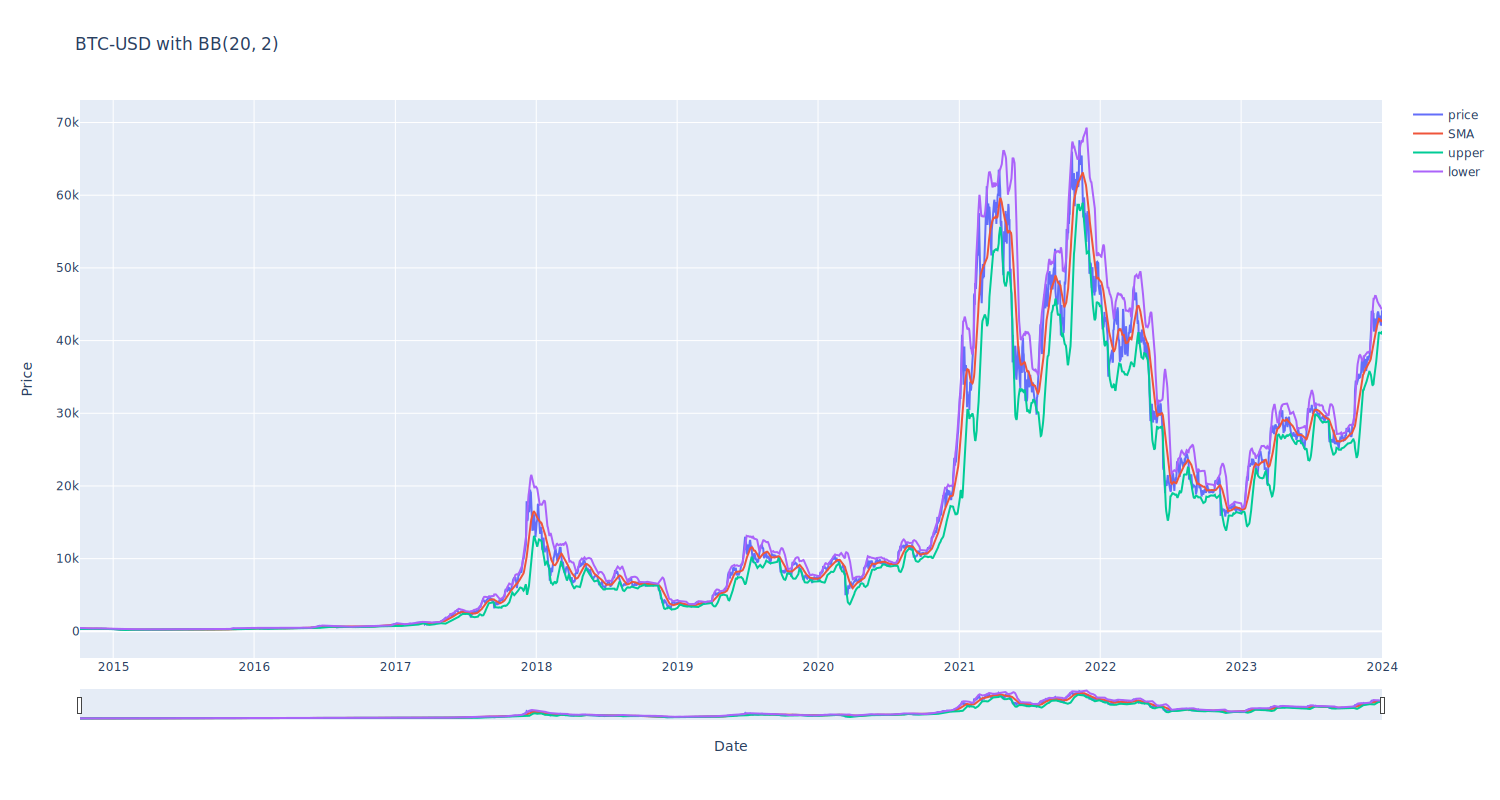

In [39]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=mrtester.results.index, y=mrtester.results['price'], mode='lines', name="price"))
# SMA
fig.add_trace(go.Scatter(x=mrtester.results.index, y=mrtester.results["SMA"], mode='lines', name="SMA"))
# upper band
fig.add_trace(go.Scatter(x=mrtester.results.index, y=mrtester.results["upper"], mode='lines', name="upper"))
# lower band
fig.add_trace(go.Scatter(x=mrtester.results.index, y=mrtester.results["lower"], mode='lines', name="lower"))


fig.update_layout(
    yaxis_title="Price",
    xaxis_title="Date",
    title=f"{mrtester.symbol} with BB({mrtester.SMA}, {mrtester.sd})",
    hovermode="x unified",
    width=1500,
    height=800
)
fig.update_xaxes(rangeslider_visible=True, rangeslider_thickness = 0.05)
fig.show(renderer="svg")

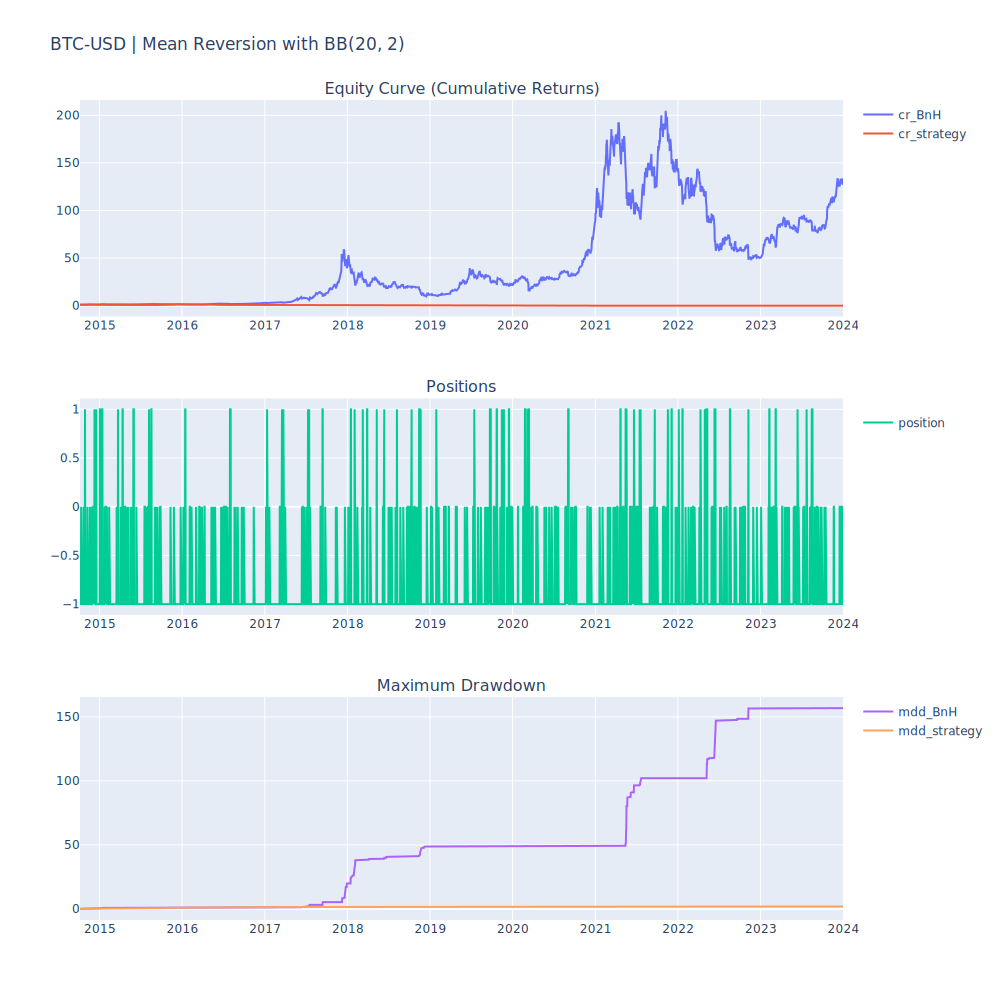

In [40]:
mrtester.plot_results()

## Summary

Apparently, the Mean Reversion strategy performs badly in terms of ROC, and the performance is far worse than just Buy-and-Hold.

One part of the strategy that is better than Buy-and-Hold is the Maximum Drawdown. As we can see from the price chart, BTC-USD prices are extremely volatile and so is the performance of Buy-and-Hold. The Mean Reversion strategy offers a much lower Maximum Drawdown for a portfolio, but the MDD is still 183.20%, which cannot be considered as stable for traders.

The above Mean Reversion strategy does not seem appealing here.

## Trend Following - Using SMA Crossover

Strategy:

Here we use SMA-10 and SMA-50
- Long if SMA-10 crosses up SMA-50
- Short if SMA-10 crosses down SMA-50

Dataset used for backtesting:

BTC-USD daily close prices from 2014-09-17 to 2024-01-01

In [41]:
class TFBackTester():
    '''
    Class for the backtesting of Trend Following strategies using SMA crossover
    '''
    def __init__(self, symbol, SMA_s, SMA_l, start, end, tc):
        '''
        Parameters
        ==========
        symbol: str
        ticker symbol to be backtested

        SMA_s: int
        simple moving average in days with the shorter term

        SMA_l: int
        simple moving average in days with the longer term

        start: str
        start date for data import

        end: str
        end date for data import

        tc: float
        proportional transaction/trading costs per trade

        Methods
        =======
        load_data:
        imports data from the csv file

        prep_data:
        prepares data for strategy backtesting

        test_strategy:
        backtests the strategy

        plot_results:
        plots the results of the strategy and compares to Buy-and-Hold
        '''
        self.symbol = symbol
        self.SMA_s = SMA_s
        self.SMA_l = SMA_l
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.load_data()
        self.prep_data()
    
    def __repr__(self):
        rep = "TFBackTester(symbol = {}, SMA_s = {}, SMA_l = {}, start = {}, end = {}, tc = {})"
        return rep.format(self.symbol, self.SMA_s, self.SMA_l, self.start, self.end, self.tc)

    def load_data(self):
        '''
        imports data from the csv file
        '''
        raw = pd.read_csv(file_path + "data/raw.csv") # the file path
        raw["Date"] = pd.to_datetime(raw["Date"], utc=True)
        raw.set_index("Date", inplace=True)
        raw.index = raw.index.strftime("%Y-%m-%d")
        raw.dropna(inplace=True)
        raw = raw.loc[self.start:self.end, ["Close"]].copy()
        raw.rename(columns={"Close": "price"}, inplace=True)
        self.data = raw
    
    def prep_data(self):
        '''
        prepares data for strategy backtesting
        '''
        data = self.data.copy()
        data["log_return"] = np.log(data / data.shift(1))
        data["SMA_s"] = data["price"].rolling(self.SMA_s).mean()
        data["SMA_l"] = data["price"].rolling(self.SMA_l).mean()
        self.data = data
    
    def test_strategy(self):
        '''
        backtests the strategy:
        long if the short SMA crosses up the long SMA,
        short if the short SMA crosses down the long SMA,
        '''
        data = self.data.copy().dropna()

        # strategy and returns, net of trading costs
        data["position"] = np.where(data.SMA_s > data.SMA_l, 1, -1)
        data["lr_strategy"] = data.position.shift(1) * data.log_return
        data["trades"] = data.position.diff().fillna(0).abs()
        data.lr_strategy = data.lr_strategy - data.trades * self.tc
        data.dropna(inplace=True)

        # cumulative returns, MDD - BnH vs strategy
        data["cr_BnH"] = data.log_return.cumsum().apply(np.exp)
        data["cr_strategy"] = data.lr_strategy.cumsum().apply(np.exp)
        data["cummax_BnH"] = data.cr_BnH.cummax()
        data["mdd_BnH"] = (data.cummax_BnH - data.cr_BnH).cummax()
        data["cummax_strategy"] = data.cr_strategy.cummax()
        data["mdd_strategy"] = (data.cummax_strategy - data.cr_strategy).cummax()
        self.results = data

        roc = data["cr_strategy"].iloc[-1] - 2 * self.tc # return on capital of the strategy
        outperf = roc - data["cr_BnH"].iloc[-1] # out-/under-performance of the strategy vs Buy-and-Hold
        mdd_BnH = data.mdd_BnH.max()
        mdd_strategy = data.mdd_strategy.max()
        return round(roc, 6), round(outperf, 6), round(mdd_BnH, 6), round(mdd_strategy, 6)

    def plot_results(self):
        '''
        plots the results of the strategy and compares to Buy-and-Hold
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            fig = make_subplots(rows=3,
                                cols=1,
                                subplot_titles=("Equity Curve (Cumulative Returns)", "Positions", "Maximum Drawdown"),
                                row_width=[0.34, 0.33, 0.33],
                                vertical_spacing=0.1)
            
            # equity curve
            fig.append_trace(go.Scatter(x=self.results.index, y=self.results["cr_BnH"], mode='lines', name="cr_BnH", legendgroup = '1'),
                             row=1, col=1)
            fig.append_trace(go.Scatter(x=self.results.index, y=self.results["cr_strategy"], mode='lines', name="cr_strategy", legendgroup = '1'),
                             row=1, col=1)
            
            # positions
            fig.append_trace(go.Scatter(x=self.results.index, y=self.results["position"], mode='lines', name="position", legendgroup = '2'),
                             row=2, col=1)

            # maximum drawdown
            fig.append_trace(go.Scatter(x=self.results.index, y=self.results["mdd_BnH"], mode='lines', name="mdd_BnH", legendgroup = '3'),
                             row=3, col=1)
            fig.append_trace(go.Scatter(x=self.results.index, y=self.results["mdd_strategy"], mode='lines', name="mdd_strategy", legendgroup = '3'),
                             row=3, col=1)
            
            fig.update_layout(width=1000, height=1000,
                              title=f"{self.symbol} | Trend Following with SMA-{self.SMA_s}, SMA-{self.SMA_l}",
                              hovermode="x unified",
                              legend_tracegroupgap=270)
            fig.show(renderer="svg")

In [42]:
tftester = TFBackTester("BTC-USD", 10, 50, "2014-09-17", "2024-01-01", 0)

In [43]:
tf_roc, tf_outperf, mdd_BnH, tf_mdd = tftester.test_strategy()

print("Backtesting results for the Trend Following strategy")
print("========")
print(f"Return On Capital: {tf_roc*100:.2f}%")
print(f"Under-/Out-performance vs Buy-and-Hold: {tf_outperf*100:.2f}%")
print(f"Maximum Drawdown of Buy-and-Hold: {mdd_BnH*100:.2f}%")
print(f"Maximum Drawdown of the strategy: {tf_mdd*100:.2f}%")

Backtesting results for the Trend Following strategy
Return On Capital: 43754.39%
Under-/Out-performance vs Buy-and-Hold: 30744.33%
Maximum Drawdown of Buy-and-Hold: 15252.34%
Maximum Drawdown of the strategy: 15986.21%


Let's also observe the strategy and its backtesting results on charts.

The SMA-10 and SMA-50 generated from the BTC-USD prices are shown in the graph below.

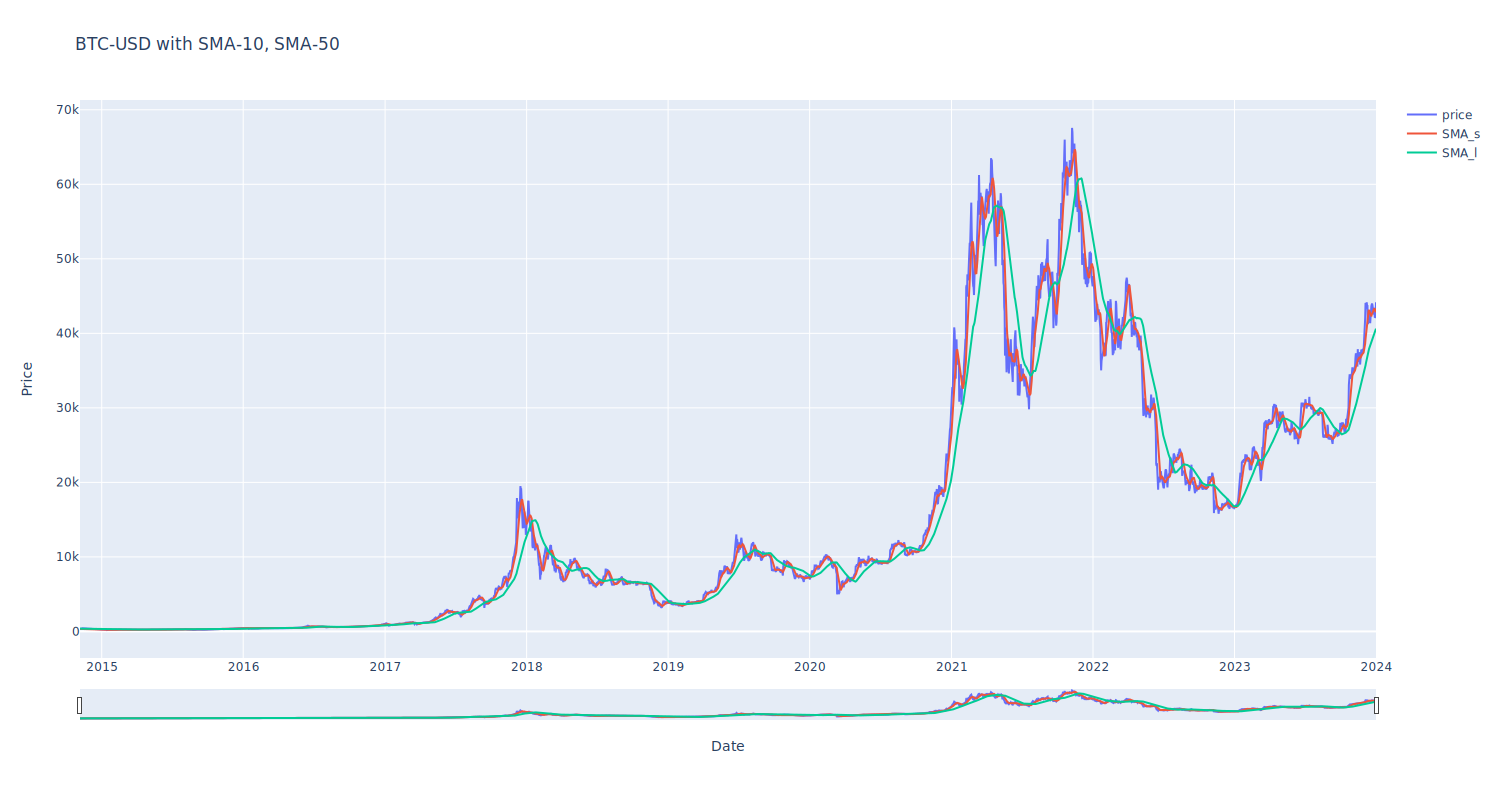

In [44]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=tftester.results.index, y=tftester.results['price'], mode='lines', name="price"))
# SMA_s
fig.add_trace(go.Scatter(x=tftester.results.index, y=tftester.results["SMA_s"], mode='lines', name="SMA_s"))
# SMA_l
fig.add_trace(go.Scatter(x=tftester.results.index, y=tftester.results["SMA_l"], mode='lines', name="SMA_l"))


fig.update_layout(
    yaxis_title="Price",
    xaxis_title="Date",
    title=f"{tftester.symbol} with SMA-{tftester.SMA_s}, SMA-{tftester.SMA_l}",
    hovermode="x unified",
    width=1500,
    height=800
)
fig.update_xaxes(rangeslider_visible=True, rangeslider_thickness = 0.05)
fig.show(renderer="svg")

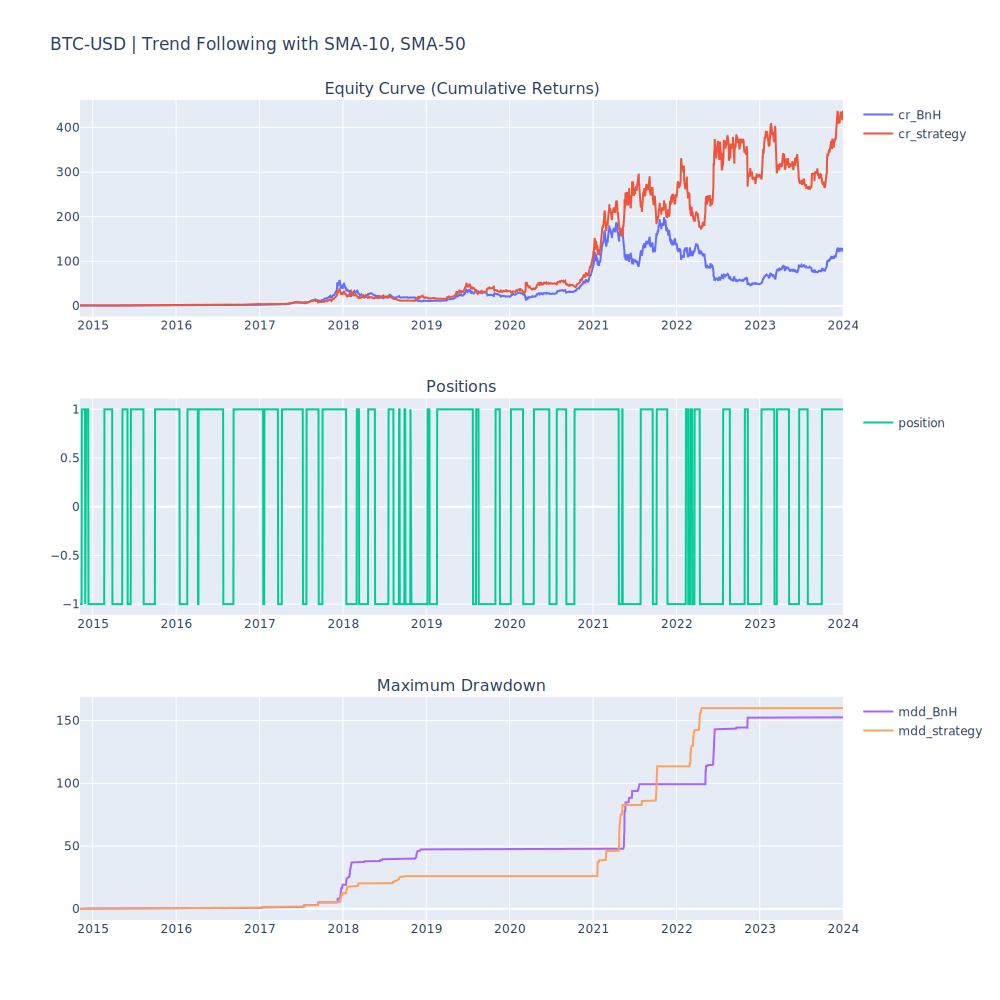

In [45]:
tftester.plot_results()

## Summary

In contrast to the Mean Reversion strategy, this Trend Following strategy performs quite well in the backtesting, and it even outperforms the Buy-and-Hold strategy. (ROC of strategy: 43754%; outperform by: 30744%)

We can see from the Equity Curve chart that the strategy starts to outperform quite well starting from the big dip in March 2020. We might speculate that, from that point onwards, the trend and momentum of the market for BTC-USD might become much more apparent and the above simple Trend Following strategy could still capture the trend quite well. The market for BTC-USD might be more of a Trend-Following one than a Mean-Reversion one (i.e. it is easier to perform well using Trend-Following strategies than Mean-Reversion strategies). This echoes the events happening in the market that more and more institutions seem to be interested in the new asset class and there might be an ongoing big influx of money into Bitcoin, especially starting after March 2020.

One shortfall of the above strategy is its MDD. Its MDD is similar to the Buy-and-Hold strategy, which can go up to 15986%. It is a strategy that could outperform Buy-and-Hold but is still very volatile, and is not ideal for traders who are looking for a stable performance.